In [55]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#imports for user defined functions
from env import host, user, password, get_db_url

# Imports for arithmetic calculations and data frame manipulation
import math
import numpy as np
import pandas as pd

#imports for splitting data and imputing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression 

from math import sqrt
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

import viz

from pydataset import data

import wrangle as wr

# Modeling Preparation

---

### Clustering

In [56]:
# split the data
train, validate, test = wr.wrangle_zillow()

cols = ['parcelid','logerror', 'bathroomcnt',
                     'bedroomcnt', 'calculatedfinishedsquarefeet',
                     'fips', 'yearbuilt', 'propertylandusedesc', 'taxvaluedollarcnt']

train = train[cols]
validate = validate[cols]
test = test[cols]   

In [57]:
train = train.rename(columns={'bathroomcnt':'bathrooms', 
                                          'bedroomcnt':'bedrooms',
                                          'calculatedfinishedsquarefeet':'square_feet',
                                          'fips':'county', 'yearbuilt':'year_built', 
                                          'propertylandusedesc':'property_type', 
                                          'taxvaluedollarcnt': 'home_value'})
    
validate = validate.rename(columns={'bathroomcnt':'bathrooms', 
                                          'bedroomcnt':'bedrooms',
                                          'calculatedfinishedsquarefeet':'square_feet',
                                          'fips':'county', 'yearbuilt':'year_built', 
                                          'propertylandusedesc':'property_type', 
                                          'taxvaluedollarcnt': 'home_value'})
    
test = test.rename(columns={'bathroomcnt':'bathrooms', 
                                          'bedroomcnt':'bedrooms',
                                          'calculatedfinishedsquarefeet':'square_feet',
                                          'fips':'county', 'yearbuilt':'year_built', 
                                          'propertylandusedesc':'property_type', 
                                          'taxvaluedollarcnt': 'home_value'})

# set counties
county = {6037:'Los Angeles', 6059:'Orange', 6111:'Ventura'}

train.county = train.county.map(county)

validate.county = validate.county.map(county)

test.county = test.county.map(county)




# changing data types
train.bedrooms = train.bedrooms.astype(int)
train.square_feet = train.square_feet.astype(int)
train.year_built = train.year_built.astype(int)
train.home_value = train.home_value.astype(int)

validate.bedrooms = validate.bedrooms.astype(int)
validate.square_feet = validate.square_feet.astype(int)
validate.year_built = validate.year_built.astype(int)
validate.home_value = validate.home_value.astype(int)

test.bedrooms = test.bedrooms.astype(int)
test.square_feet = test.square_feet.astype(int)
test.year_built = test.year_built.astype(int)
test.home_value = test.home_value.astype(int)


# omit outliers
cols = ['bathrooms', 'bedrooms', 'square_feet']

train = wr.omit_outliers(train, 1.5, cols)
validate = wr.omit_outliers(validate, 1.5, cols)
test = wr.omit_outliers(test, 1.5, cols)

In [58]:
train['property_age'] = (train.year_built.max() - train.year_built)
validate['property_age'] = (validate.year_built.max() - validate.year_built)
test['property_age'] = (test.year_built.max() - test.year_built)

In [59]:
train.head()

,parcelid,logerror,bathrooms,bedrooms,square_feet,county,year_built,property_type,home_value,property_age
35021,12456239,0.110467,1.0,1,480,Los Angeles,1942,Single Family Residential,45881,74
5579,12864000,0.000151,4.0,5,2828,Los Angeles,1962,Single Family Residential,148451,54
71705,14733743,0.054847,2.5,2,1150,Orange,1998,Condominium,311854,18
57277,17075614,0.092856,3.0,3,2046,Ventura,1990,Single Family Residential,796305,26
45925,11177880,-0.041157,2.0,2,1028,Los Angeles,1985,Single Family Residential,270563,31


In [60]:
validate.head()

,parcelid,logerror,bathrooms,bedrooms,square_feet,county,year_built,property_type,home_value,property_age
3675,11130531,-0.425763,3.0,3,1491,Los Angeles,1966,Condominium,192441,50
16684,11632814,0.371452,1.0,1,715,Los Angeles,1973,Condominium,369643,43
37139,13058762,-0.012303,3.0,3,1745,Los Angeles,1986,Single Family Residential,363524,30
64845,14740251,0.099253,2.5,3,1345,Orange,1993,Condominium,489000,23
39181,11110296,-0.044703,2.0,3,1418,Los Angeles,1966,Single Family Residential,66984,50


In [61]:
# create scaled copies
train_scaled, validate_scaled, test_scaled = wr.scale_data(train, validate, test)

df = train_scaled.copy()
df=df.reset_index()

---

### Property Size Cluster

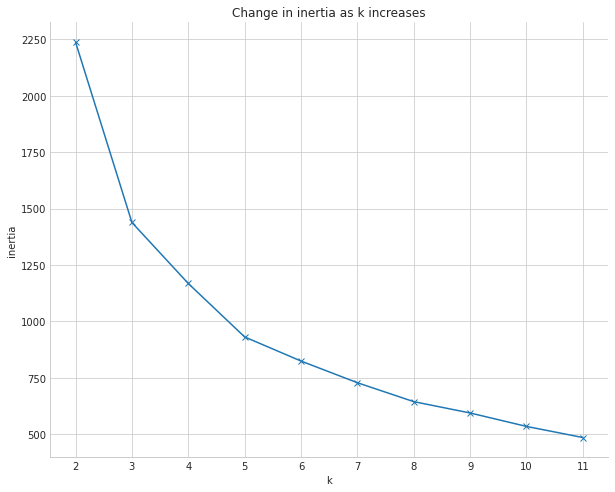

In [8]:
X = df[['square_feet', 'bedrooms', 'bathrooms']]


with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10,8))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [9]:
#Create the KMeans model
kmeans = KMeans(n_clusters = 4)

#Fit the model
kmeans.fit(X)

#Make predictions and assign the values to the original train data set
train['property_size_cluster'] = kmeans.predict(X)

---

### Property Age

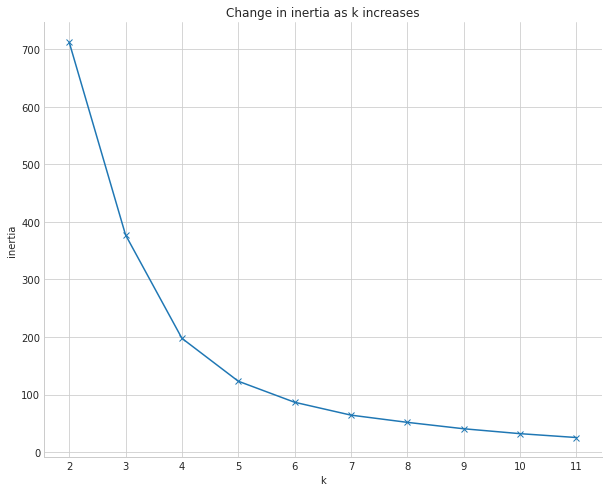

In [10]:
X2 = df[['property_age', 'year_built']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10,8))
    pd.Series({k: KMeans(k).fit(X2).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [11]:
#Create the KMeans model
kmeans = KMeans(n_clusters = 4)

#Fit the model
kmeans.fit(X2)

#Make predictions and assign the values to the original train data set
train['age_cluster'] = kmeans.predict(X2)

---

In [12]:
df.head()

,index,parcelid,logerror,bathrooms,bedrooms,square_feet,county,year_built,property_type,home_value,property_age
0,35021,12456239,0.110467,0.000000,0.166667,0.105704,Los Angeles,0.447761,Single Family Residential,0.004574,0.552239
1,5579,12864000,0.000151,1.000000,0.833333,0.862391,Los Angeles,0.597015,Single Family Residential,0.015579,0.402985
2,71705,14733743,0.054847,0.500000,0.333333,0.321624,Orange,0.865672,Condominium,0.033112,0.134328
3,57277,17075614,0.092856,0.666667,0.500000,0.610377,Ventura,0.805970,Single Family Residential,0.085094,0.194030
4,45925,11177880,-0.041157,0.333333,0.333333,0.282307,Los Angeles,0.768657,Single Family Residential,0.028682,0.231343


### Modeling:

In [13]:
mvp = ['bedrooms', 'bathrooms', 'square_feet', 'year_built', 'home_value',
       'property_age']

In [14]:
X_train, y_train = train_scaled[mvp], train_scaled.logerror
X_validate, y_validate = validate_scaled[mvp], validate_scaled.home_value
X_test, y_test = test_scaled[mvp], test_scaled.home_value

In [15]:
X_train.head()

,bedrooms,bathrooms,square_feet,year_built,home_value,property_age
35021,0.166667,0.000000,0.105704,0.447761,0.004574,0.552239
5579,0.833333,1.000000,0.862391,0.597015,0.015579,0.402985
71705,0.333333,0.500000,0.321624,0.865672,0.033112,0.134328
57277,0.500000,0.666667,0.610377,0.805970,0.085094,0.194030
45925,0.333333,0.333333,0.282307,0.768657,0.028682,0.231343


In [16]:
X_validate.head()

,bedrooms,bathrooms,square_feet,year_built,home_value,property_age
3675,0.500000,0.666667,0.431518,0.626866,0.020300,0.373134
16684,0.166667,0.000000,0.181437,0.679104,0.039313,0.320896
37139,0.500000,0.666667,0.513374,0.776119,0.038657,0.223881
64845,0.500000,0.500000,0.384467,0.828358,0.052120,0.171642
39181,0.500000,0.333333,0.407992,0.626866,0.006838,0.373134


In [17]:
X_test.head()

,bedrooms,bathrooms,square_feet,year_built,home_value,property_age
50829,0.333333,0.333333,0.338704,0.522388,0.021352,0.477612
23979,0.500000,0.333333,0.521753,0.932836,0.071648,0.067164
18367,0.333333,0.333333,0.293587,0.805970,0.040854,0.194030
35246,0.500000,0.333333,0.500483,0.298507,0.029438,0.701493
28553,0.500000,0.333333,0.538511,0.686567,0.027730,0.313433


In [18]:
X_train.head()

,bedrooms,bathrooms,square_feet,year_built,home_value,property_age
35021,0.166667,0.000000,0.105704,0.447761,0.004574,0.552239
5579,0.833333,1.000000,0.862391,0.597015,0.015579,0.402985
71705,0.333333,0.500000,0.321624,0.865672,0.033112,0.134328
57277,0.500000,0.666667,0.610377,0.805970,0.085094,0.194030
45925,0.333333,0.333333,0.282307,0.768657,0.028682,0.231343


### Implementing Clusters to the dataframe

### Property Size

In [50]:
# property size cluster

#Create the KMeans model

cols = ['square_feet', 'bedrooms', 'bathrooms']

X = X_train[cols]

kmeans = KMeans(n_clusters = 4)

#Fit the model
kmeans.fit(X)

#Make predictions and assign the values to the original train data set
X_train['property_size_cluster'] = kmeans.predict(X)

# Now for validate
X = X_validate[cols]

X_validate['property_size_cluster'] = kmeans.predict(X)

# Then test
X = X_test[cols]
X_test['property_size_cluster'] = kmeans.predict(X)


### Age of Property Cluster

In [36]:
cols2 = ['property_age', 'year_built']

X2 = X_train[cols2]

#Create the KMeans model
kmeans = KMeans(n_clusters = 3)

#Fit the model
kmeans.fit(X2)

#Make predictions and assign the values to the original train data set
X_train['age_cluster'] = kmeans.predict(X2)

X2 = X_validate[cols2]

X_validate['age_cluster'] = kmeans.predict(X2)

X2 = X_test[cols2]
X_test['age_cluster'] = kmeans.predict(X2)

### Create the baseline: 

In [51]:
#First convert y_train into Dataframes so the baselines can be easily calculated with pandas
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test =pd.DataFrame(y_test)

# Create new data frame to hold my in sample predictions and the same for out of sample
pred_train = y_train.copy()
pred_train = pred_train.rename(columns={'logerror':'actual'})
pred_validate = y_validate.copy()
pred_validate = pred_validate.rename(columns={'home_value':'actual'})
pred_test = y_test.copy()
pred_test = pred_test.rename(columns={'home_value':'actual'})


#Calculate based on mean and add baseline predictions to a the train data frame holding predictions
baseline_mean = train.logerror.mean()
pred_train['baseline_mean'] = baseline_mean
pred_validate['baseline_mean'] = baseline_mean
pred_test['baseline_mean'] = baseline_mean

#Calculate based on median and add baseline predictions to the train data frame holding predictions
baseline_median = train.logerror.median()
pred_train['baseline_median'] = baseline_median
pred_validate['baseline_median'] = baseline_median
pred_test['baseline_median'] = baseline_median

In [52]:
pred_train

,actual,baseline_mean,baseline_median
35021,0.110467,0.014827,0.005951
5579,0.000151,0.014827,0.005951
71705,0.054847,0.014827,0.005951
57277,0.092856,0.014827,0.005951
45925,-0.041157,0.014827,0.005951
...,...,...,...
13951,0.015971,0.014827,0.005951
5,-0.020526,0.014827,0.005951
14432,-0.013856,0.014827,0.005951
53764,-0.028346,0.014827,0.005951


In [53]:
pred_test.head()

,actual,baseline_mean,baseline_median
50829,0.021352,0.014827,0.005951
23979,0.071648,0.014827,0.005951
18367,0.040854,0.014827,0.005951
35246,0.029438,0.014827,0.005951
28553,0.027730,0.014827,0.005951


#### RMSE mean is a lower number which indicates a more predictive model so I will use it as the baseline.

In [54]:
# RMSE of baseline mean
rmse_train = mean_squared_error(pred_train.actual,
                                pred_train.baseline_mean)

rmse_validate = mean_squared_error(pred_validate.actual,
                                   pred_validate.baseline_mean)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 7), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 7))

print(' ')
print('----------------------------------------------------------')
print(' ')

# RMSE of baseline median
rmse_train = mean_squared_error(pred_train.actual,
                                pred_train.baseline_median)

rmse_validate = mean_squared_error(pred_validate.actual,
                                   pred_validate.baseline_median)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 7), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 7))

RMSE using Mean
Train/In-Sample:  0.0246766 
Validate/Out-of-Sample:  0.0023911
 
----------------------------------------------------------
 
RMSE using Median
Train/In-Sample:  0.0247554 
Validate/Out-of-Sample:  0.0029766


### Ordinary Least Squares Model:

In [41]:
# set linearRegression model
lm = LinearRegression(normalize=True)

lm.fit(X_train, y_train)

# make predictions
pred_train['ols'] = lm.predict(X_train)
pred_validate['ols'] = lm.predict(X_validate)


rmse_train1 = mean_squared_error(pred_train.actual,
                                pred_train.ols)

rmse_validate1 = mean_squared_error(pred_validate.actual,
                                pred_validate.ols)

In [42]:
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train1, 7), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate1, 7))

RMSE using Median
Train/In-Sample:  0.0246267 
Validate/Out-of-Sample:  0.0027248


### Lasso + Lars

In [43]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train)

# predict 
pred_train['lars'] = lars.predict(X_train)
pred_validate['lars'] = lars.predict(X_validate)


# evaluate: rmse
rmse_train4 = mean_squared_error(pred_train.actual, pred_train.lars)

# evaluate: rmse
rmse_validate4 = mean_squared_error(pred_validate.actual, pred_validate.lars)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train4, 7), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate4, 7))

RMSE using Median
Train/In-Sample:  0.0246766 
Validate/Out-of-Sample:  0.0023911


# OLM has lower, but still not better than baseline model.

In [44]:
pred_test

,actual,baseline_mean,baseline_median
50829,0.021352,0.014827,0.005951
23979,0.071648,0.014827,0.005951
18367,0.040854,0.014827,0.005951
35246,0.029438,0.014827,0.005951
28553,0.027730,0.014827,0.005951
...,...,...,...
23878,0.036418,0.014827,0.005951
20218,0.038917,0.014827,0.005951
16088,0.012019,0.014827,0.005951
8713,0.022804,0.014827,0.005951


In [46]:
X_test.shape

(13312, 8)

In [48]:
#Perform on test.
# Results = Good, but not better than the baseline

In [49]:
# predict on test
pred_test['ols'] = lm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(pred_test.actual, pred_test.ols)

print("RMSE for Polynomial Regression using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Polynomial Regression using LinearRegression
Out-of-Sample Performance:  0.0024245094390248473
